In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# 卷积层

In [3]:
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255

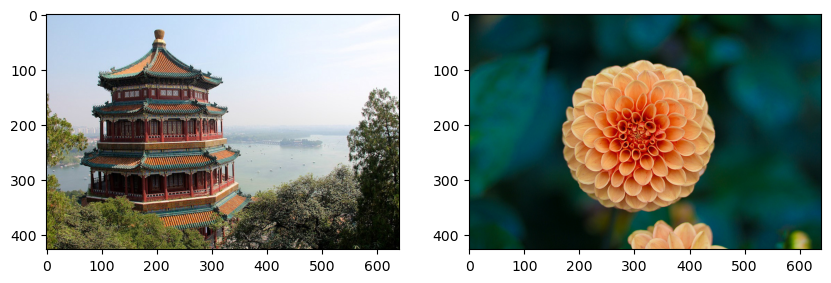

In [4]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(china)
plt.subplot(122)
plt.imshow(flower)

In [5]:
china.shape

(427, 640, 3)

In [6]:
images = np.array([china, flower])

In [7]:
batch_size, hight, wight, channels = images.shape

In [8]:
images.shape

(2, 427, 640, 3)

> 请勿在实际案例使用以下方法，仅演示手动构建滤波器

In [9]:
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) # 创建两个7*7滤波器

In [10]:
filters.shape

(7, 7, 3, 2)

In [11]:
filters[:, 3, :, 0] = 1 # 垂直线，即设定为垂直滤波器，试想，先行后列：行全选，第三列选中，纵（z轴）全选，第一（0）个滤波器，填充为1，即垂直滤波
filters[3, :, :, 1] = 1 # 水平线，水平滤波器

In [12]:
filters[..., 1]
# 第一维中每个矩阵代表一行像素块，矩阵中一行代表一个像素块的RGB值
# 除了第一维第三个矩阵全部是1（该行白色），其他的都是0（该行黑色）

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]

In [13]:
with tf.device("/cpu:0"): # 深度最大池化只能用CPU    
    outputs = tf.nn.max_pool(images, 
                         ksize=(1 ,1 ,1 ,3) , 
                         strides=(1 ,1 ,1 ,3), 
                         padding="VALID")

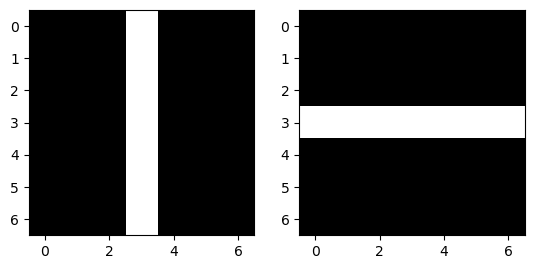

In [14]:
plt.subplot(121)
plt.imshow(filters[..., 0], cmap='gray')
plt.subplot(122)
plt.imshow(filters[..., 1], cmap='gray')

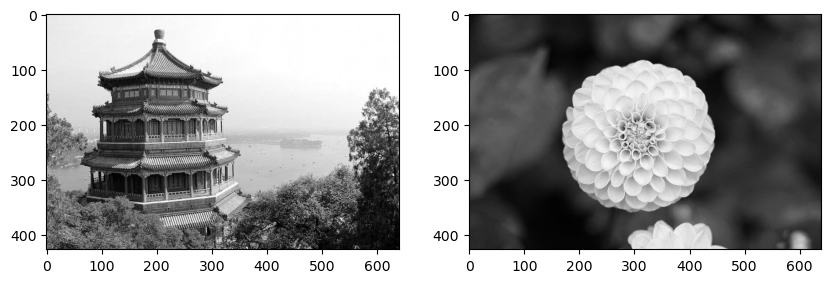

In [15]:
plt.figure(figsize=(10, 10))

plt.subplot(121)

plt.imshow(outputs[0, :, :, 0], cmap='gray')

plt.subplot(122)

plt.imshow(outputs[1, :, :, 0], cmap='gray')

> TF已经给了构建滤波器的函数如下，它可以被训练因此不用具体定义滤波器

In [16]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')
# 滤波器数量，高宽（方形高宽一致），步幅，填充类型，激活函数

# 池化层

池化层只保留核内最大值（或平均值），大幅压缩图像，具有一定破坏性

In [17]:
max_pool = keras.layers.MaxPool2D(pool_size=2) # 平均池化层使用 Avgpool2D()

In [18]:
# Keras不包括深度最大池化层，TF的低层深度学习API包括
with tf.device("/cpu:0"): # 深度最大池化只支持CPU
    output = tf.nn.max_pool(images,
                       ksize=(1, 1, 1, 3),
                       strides=(1, 1, 1, 3),
                       padding='VALID')
# 内核大小和步幅指定为4元组，前三个值均为1：即内核大小、步幅和批量处理、高度宽度应为1，
# 最后一个应该为沿深度维度所需的内核大小和跨度，如3，必须是输入深度的除数，如果上一层输出20，则无效，因为20不是3的倍数

In [19]:
# 也可以包装在keras内
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding='VALID'))

# 调用 depth_pool(image)，输入图像即可

In [20]:
'''现代构架中经常会看到最后一种池化层是全局平均池化层，它计算整个特征图的均值，意味着每个特征图只输出一个单值，极具破坏性
但它可以作用输出层'''
global_avg_pool = keras.layers.GlobalAveragePooling2D()
# 等效于
global_avd_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))

# CNN构架

In [21]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True) # 均值
X_std = X_train.std(axis=0, keepdims=True) + 1e-7 # 标准差
X_train = (X_train - X_mean) / X_std # 训练集标准化
X_valid = (X_valid - X_mean) / X_std # 验证集标准化
X_test = (X_test - X_mean) / X_std # 测试集标准化

In [22]:
X_train.shape

(55000, 28, 28)

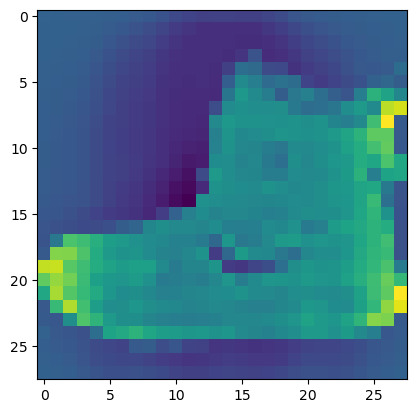

In [23]:
plt.imshow(X_train[0,...])

In [24]:
X_train = X_train[..., np.newaxis] # 增加一个维度,暂时不清楚为什么
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [25]:
X_train[0,1,5]

array([-0.1306924])

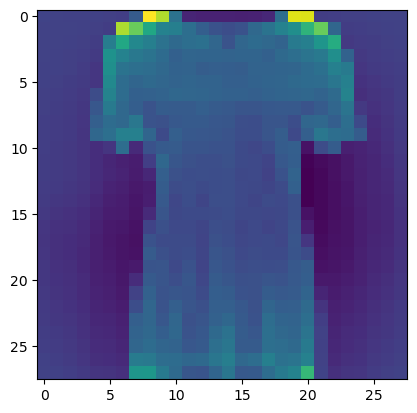

In [26]:
plt.imshow(X_train[10])

## 定义模型

In [30]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, 
                       activation='relu', 
                       padding='same',
                       input_shape=[28, 28, 1]), 
    # 👆 64个滤波器，核高宽7（卷积层），核越大保留信息越多 
    keras.layers.MaxPool2D(2), # 池化层，大小2，在每个维度除以2(等于步幅)
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    # 重复滤波、池化，每池化一次，滤波器数理加倍，因为池化后空间维度除以2，不用担心参数爆炸增长
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(), # 把图像转为一维数组，接上全连接网络
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5), # 每次drop一半神经元防止过拟合
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"), # 10分类
    ])

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 256)        

In [28]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 35s 17ms/step - loss: 0.7312 - accuracy: 0.7455 - val_loss: 0.3623 - val_accuracy: 0.8638
Epoch 2/5
1719/1719 [==============================] - 28s 16ms/step - loss: 0.4332 - accuracy: 0.8544 - val_loss: 0.3635 - val_accuracy: 0.8686
Epoch 3/5
1719/1719 [==============================] - 28s 16ms/step - loss: 0.3734 - accuracy: 0.8735 - val_loss: 0.2979 - val_accuracy: 0.8932
Epoch 4/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.3378 - accuracy: 0.8845 - val_loss: 0.3386 - val_accuracy: 0.8820
Epoch 5/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.3104 - accuracy: 0.8944 - val_loss: 0.2999 - val_accuracy: 0.8920


<Axes: >

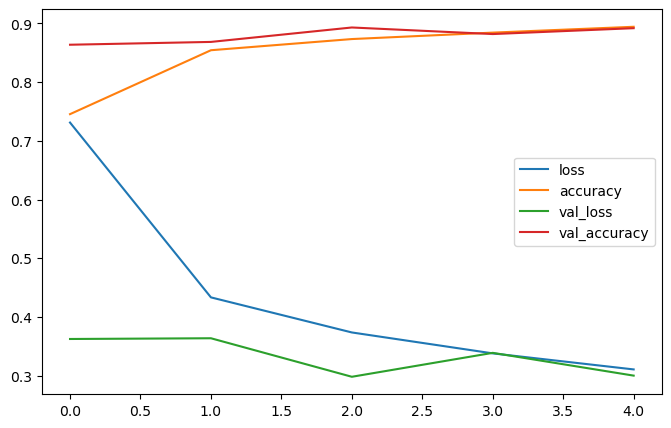

In [29]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))